In [ ]:
import pandas as pd
import numpy as np
from IPython.display import Image
import warnings

warnings.filterwarnings('ignore')

np.set_printoptions(suppress = True)

In [ ]:
from sklearn.datasets import load_boston

In [ ]:
#데이터 로드 
data = load_boston()

df = pd.DataFrame(data['data'], columns=data['feature_names'])
df['MEDV'] = data['target']

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df.drop('MEDV', 1), df['MEDV'], random_state=42)

In [ ]:
#평가지표 만들기

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

my_predictions = {}

colors = ['r', 'c', 'm', 'y', 'k', 'khaki', 'teal', 'orchid', 'sandybrown',
          'greenyellow', 'dodgerblue', 'deepskyblue', 'rosybrown', 'firebrick',
          'deeppink', 'crimson', 'salmon', 'darkred', 'olivedrab', 'olive', 
          'forestgreen', 'royalblue', 'indigo', 'navy', 'mediumpurple', 'chocolate',
          'gold', 'darkorange', 'seagreen', 'turquoise', 'steelblue', 'slategray', 
          'peru', 'midnightblue', 'slateblue', 'dimgray', 'cadetblue', 'tomato'
         ]

def plot_predictions(name_, pred, actual):
    df = pd.DataFrame({'prediction': pred, 'actual': y_test})
    df = df.sort_values(by='actual').reset_index(drop=True)

    plt.figure(figsize=(12, 9))
    plt.scatter(df.index, df['prediction'], marker='x', color='r')
    plt.scatter(df.index, df['actual'], alpha=0.7, marker='o', color='black')
    plt.title(name_, fontsize=15)
    plt.legend(['prediction', 'actual'], fontsize=12)
    plt.show()

def mse_eval(name_, pred, actual):
    global predictions
    global colors

    plot_predictions(name_, pred, actual)

    mse = mean_squared_error(pred, actual)
    my_predictions[name_] = mse

    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=True)
    
    df = pd.DataFrame(y_value, columns=['model', 'mse'])
    print(df)
    min_ = df['mse'].min() - 10
    max_ = df['mse'].max() + 10
    
    length = len(df)
    
    plt.figure(figsize=(10, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=15)
    bars = ax.barh(np.arange(len(df)), df['mse'])
    
    for i, v in enumerate(df['mse']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v + 2, i, str(round(v, 3)), color='k', fontsize=15, fontweight='bold')
        
    plt.title('MSE Error', fontsize=18)
    plt.xlim(min_, max_)
    
    plt.show()

def remove_model(name_):
    global my_predictions
    try:
        del my_predictions[name_]
    except KeyError:
        return False
    return True

def plot_coef(columns, coef):
    coef_df = pd.DataFrame(list(zip(columns, coef)))
    coef_df.columns=['feature', 'coef']
    coef_df = coef_df.sort_values('coef', ascending=False).reset_index(drop=True)
    
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.barh(np.arange(len(coef_df)), coef_df['coef'])
    idx = np.arange(len(coef_df))
    ax.set_yticks(idx)
    ax.set_yticklabels(coef_df['feature'])
    fig.tight_layout()
    plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
linear_reg = LinearRegression(n_jobs=-1)
linear_reg.fit(x_train, y_train)
pred = linear_reg.predict(x_test)
mse_eval('LinearRegression', pred, y_test)

In [ ]:
ridge = Ridge(alpha=1)
ridge.fit(x_train, y_train)
pred = ridge.predict(x_test)
mse_eval('Ridge(alpha=1)', pred, y_test)

In [ ]:
lasso = Lasso(alpha=0.01)
lasso.fit(x_train, y_train)
pred = lasso.predict(x_test)
mse_eval('Lasso(alpha=0.01)', pred, y_test)

In [ ]:
elasticnet = ElasticNet(alpha=0.5, l1_ratio=0.8)
elasticnet.fit(x_train, y_train)
pred = elasticnet.predict(x_test)
mse_eval('ElasticNet(l1_ratio=0.8)', pred, y_test)    

In [ ]:
elasticnet_pipeline = make_pipeline(
    StandardScaler(),
    ElasticNet(alpha=0.1, l1_ratio=0.2)
)
elasticnet_pred = elasticnet_pipeline.fit(x_train, y_train).predict(x_test)
mse_eval('Standard ElasticNet', elasticnet_pred, y_test)

In [ ]:
poly_pipeline = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    StandardScaler(),
    ElasticNet(alpha=0.1, l1_ratio=0.2)
)
poly_pred = poly_pipeline.fit(x_train, y_train).predict(x_test)
mse_eval('Poly ElasticNet', poly_pred, y_test)

In [ ]:
###앙상블 시작!! -- 보팅

In [ ]:
from sklearn.ensemble import VotingRegressor, VotingClassifier

In [ ]:
single_models = [
    ('linear_reg', linear_reg), 
    ('ridge', ridge), 
    ('lasso', lasso), 
    ('elasticnet_pipeline', elasticnet_pipeline), 
    ('poly_pipeline', poly_pipeline)
]

In [ ]:
voting_regressor = VotingRegressor(single_models, n_jobs=-1)

In [ ]:
voting_regressor.fit(x_train, y_train)

In [ ]:
voting_pred = voting_regressor.predict(x_test)

In [ ]:
mse_eval('Voting Ensemble', voting_pred, y_test)

In [ ]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [ ]:
rfr = RandomForestRegressor()
rfr_pred = rfr.fit(x_train, y_train).predict(x_test)

In [ ]:
mse_eval('RandomForest Ensemble', rfr_pred, y_test)

In [ ]:
rfr = RandomForestRegressor(random_state=42, n_estimators = 1000, max_depth=7, max_features=0.8)
rfr_pred = rfr.fit(x_train, y_train).predict(x_test)

In [ ]:
mse_eval('RandomForest Ensemble w/ Tunning', rfr_pred, y_test)

In [ ]:
# GradientBoost
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
gbr = GradientBoostingRegressor(random_state = 42)
gbr_pred = gbr.fit(x_train, y_train).predict(x_test)
mse_eval('GradientBoosting ensemble',gbr_pred, y_test)

In [ ]:
gbr = GradientBoostingRegressor(random_state = 42, learning_rate=0.01)
gbr_pred = gbr.fit(x_train, y_train).predict(x_test)
mse_eval('GradientBoosting ensemble(lr = 0.01)',gbr_pred, y_test)

In [ ]:
gbr = GradientBoostingRegressor(random_state = 42, learning_rate=0.01, n_estimators=1000)
gbr_pred = gbr.fit(x_train, y_train).predict(x_test)
mse_eval('GradientBoosting ensemble(lr = 0.01, est=1000)',gbr_pred, y_test)

In [ ]:
gbr = GradientBoostingRegressor(random_state = 42, learning_rate=0.01, n_estimators=1000, subsample=0.8)
gbr_pred = gbr.fit(x_train, y_train).predict(x_test)
mse_eval('GradientBoosting ensemble(lr = 0.01, est=1000, subsample=0.8)',gbr_pred, y_test)

In [ ]:
from xgboost import XGBRegressor

In [ ]:
xgb = XGBRegressor(random_state = 42)
xgb_pred = xgb.fit(x_train, y_train).predict(x_test)
mse_eval('XGBoost', xgb_pred, y_test)

In [ ]:
xgb = XGBRegressor(random_state = 42, learning_rate = 0.01, n_estimators =1000, subsample = 0.8, max_features = 0.8, max_depth = 7)
xgb_pred = xgb.fit(x_train, y_train).predict(x_test)
mse_eval('XGBoost w/ Tuning', xgb_pred, y_test)

In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
lgbm = LGBMRegressor(random_state=42)
lgbm_pred = lgbm.fit(x_train, y_train).predict(x_test)
mse_eval('LGBM', lgbm_pred, y_test)

In [ ]:
lgbm = LGBMRegressor(random_state=42, learning_rate=0.01, n_estimators=2000, colsample_bytree=0.8, subsample=0.8, max_depth = 7)
lgbm_pred = lgbm.fit(x_train, y_train).predict(x_test)
mse_eval('LGBM w/ Tuning', lgbm_pred, y_test)

In [ ]:
from sklearn.ensemble import StackingRegressor

In [ ]:
stack_models = {
    ('elasticent', poly_pipeline),
    ('randomForest', rfr),
    ('gbr', gbr),
    ('lgbm', lgbm)
}

In [ ]:
stack_reg =StackingRegressor(stack_models, final_estimator=xgb, n_jobs=-1)
stack_reg_pred = stack_reg.fit(x_train, y_train).predict(x_test)
mse_eval('Stacking Ensemble', stack_reg_pred, y_test)

In [ ]:
final_outputs = {
    'elasticnet': poly_pred, 
    'randomforest': rfr_pred, 
    'gbr': gbr_pred,
    'xgb': xgb_pred, 
    'lgbm': lgbm_pred,
    'stacking': stack_reg_pred,
}

In [ ]:
final_prediction=\
final_outputs['elasticnet'] * 0.1\
+final_outputs['randomforest'] * 0.1\
+final_outputs['gbr'] * 0.2\
+final_outputs['xgb'] * 0.2\
+final_outputs['lgbm'] * 0.2\
+final_outputs['stacking'] * 0.2

In [ ]:
mse_eval('Weighted Blending', final_prediction, y_test)

In [ ]:
#하이퍼 파라미터 튜닝 
"""
-하이퍼파라미터 튜닝시 경우의 수가 너무 많음
-따라서, 자동화 필요

1. RandomizedSearchCV
2. GridSearchCV

적용하는 방법
1. 사용할 Search 방법을 선택
2. 하이퍼파라미터 도메인 성정
3. 학습을 시킨 후, 기다림
4. 도출된 결과 값을 모델에 적용하고 성능 비교
"""

In [ ]:
#RandimizedSearchCV
"""
모둔 매개 변수 값이 시도되는 것이 아니라 지정된 부포에서 고정 된 수의 매개 변수 설정이 샘플링 됨.
시도 된 매개변수 설정의 수는 n_iter 에 의해 제공됨
"""

In [59]:
params = {
    'n_estimators': [200, 500, 1000, 2000], 
    'learning_rate': [0.1, 0.05, 0.01], 
    'max_depth': [6, 7, 8], 
    'colsample_bytree': [0.8, 0.9, 1.0], 
    'subsample': [0.8, 0.9, 1.0],
}

In [60]:
from sklearn.model_selection import RandomizedSearchCV
"""
n_iter 값을 조절하여 몇 회의 시도를 진행할 것인지 정의한다
= 횟수가 늘어나면, 더좋은 parameter를 찾을 확률은 올라가지만, 그만큼 시간이 오래걸림
"""

In [62]:
clf = RandomizedSearchCV(LGBMRegressor(), params, random_state=42, cv=3, n_iter=25, scoring='neg_mean_squared_error')

In [63]:
clf.fit(x_train, y_train)

RandomizedSearchCV(cv=3, estimator=LGBMRegressor(), n_iter=25,
                   param_distributions={'colsample_bytree': [0.8, 0.9, 1.0],
                                        'learning_rate': [0.1, 0.05, 0.01],
                                        'max_depth': [6, 7, 8],
                                        'n_estimators': [200, 500, 1000, 2000],
                                        'subsample': [0.8, 0.9, 1.0]},
                   random_state=42, scoring='neg_mean_squared_error')

In [65]:
clf.best_score_

-13.707228623244996

In [66]:
clf.best_params_

{'subsample': 0.9,
 'n_estimators': 2000,
 'max_depth': 6,
 'learning_rate': 0.01,
 'colsample_bytree': 0.8}

In [67]:
lgbm_best = LGBMRegressor(n_estimators=2000, subsample=0.9,max_depth=6,learning_rate=0.01,colsample_bytree=0.8)

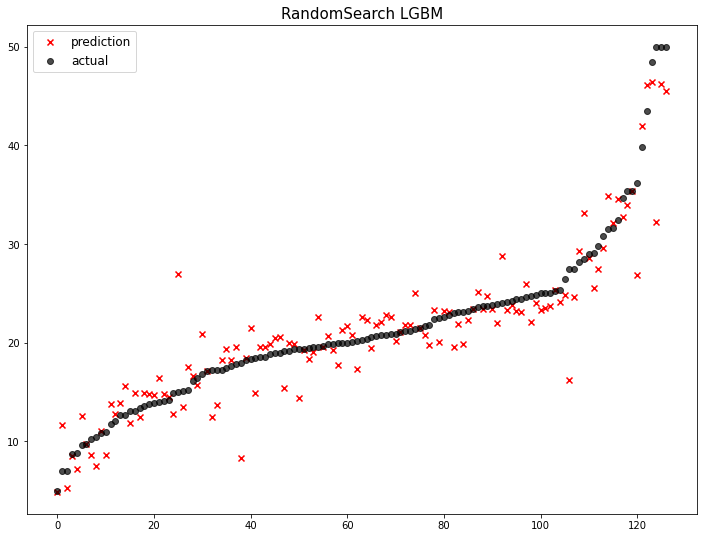

                                                model        mse
0                            ElasticNet(l1_ratio=0.8)  23.156236
1                                 Standard ElasticNet  22.694970
2                                      Ridge(alpha=1)  22.480476
3                                   Lasso(alpha=0.01)  22.210557
4                                    LinearRegression  22.098695
5                GradientBoosting ensemble(lr = 0.01)  21.982151
6                                     Voting Ensemble  20.474757
7                                     Poly ElasticNet  15.710492
8                                                LGBM  10.937726
9                                      LGBM w/ Tuning  10.296543
10                   RandomForest Ensemble w/ Tunning  10.293518
11                              RandomForest Ensemble  10.256412
12                                            XGBoost  10.061070
13                                  RandomSearch LGBM  10.024121
14                       

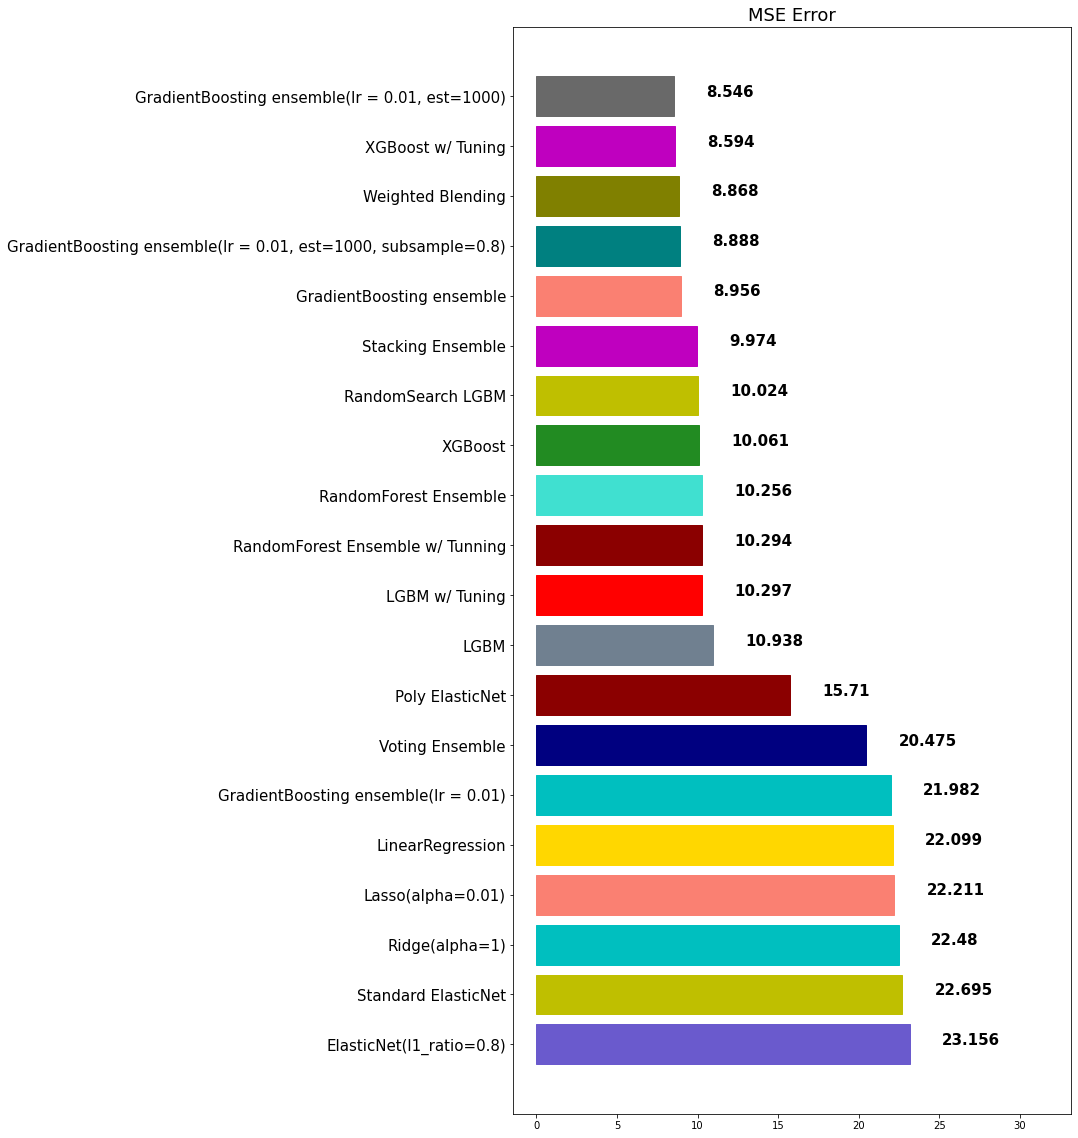

In [68]:
lgbm_best_pred = lgbm_best.fit(x_train, y_train).predict(x_test)
mse_eval('RandomSearch LGBM', lgbm_best_pred, y_test)

In [ ]:
#GridSearchCV
"""
-모든 매개 변수 값에 대하여 완전 탐색을 시도합니다.
-따라서, 최적화할 parameter 가 많다면, 시간이 매우 오래 걸림"""

In [70]:
params = {
    'n_estimators': [500, 1000], 
    'learning_rate': [0.1, 0.05, 0.01], 
    'max_depth': [7, 8], 
    'colsample_bytree': [0.8, 0.9], 
    'subsample': [0.8, 0.9,],
}

In [71]:
from sklearn.model_selection import GridSearchCV

In [72]:
grid_search = GridSearchCV(LGBMRegressor(),params, cv =3,n_jobs=1, scoring='neg_mean_squared_error')

In [73]:
grid_search.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=LGBMRegressor(), n_jobs=1,
             param_grid={'colsample_bytree': [0.8, 0.9],
                         'learning_rate': [0.1, 0.05, 0.01],
                         'max_depth': [7, 8], 'n_estimators': [500, 1000],
                         'subsample': [0.8, 0.9]},
             scoring='neg_mean_squared_error')

In [74]:
grid_search.best_score_

-13.598939419010335

In [75]:
grid_search.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.05,
 'max_depth': 7,
 'n_estimators': 500,
 'subsample': 0.8}

In [76]:
lgbm_best = LGBMRegressor(n_estimators=500, subsample=0.8,max_depth=7,learning_rate=0.05,colsample_bytree=0.8)

In [78]:
lgbm_best_pred = lgbm_best.fit(x_train,y_train).predict(x_test)

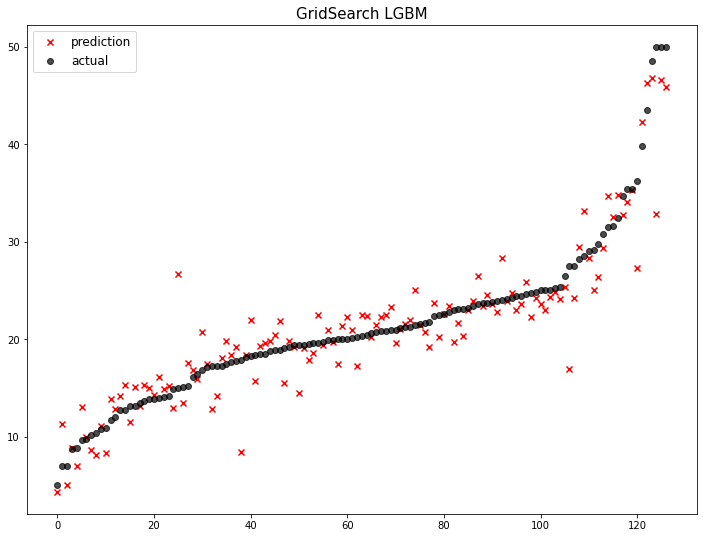

                                                model        mse
0                            ElasticNet(l1_ratio=0.8)  23.156236
1                                 Standard ElasticNet  22.694970
2                                      Ridge(alpha=1)  22.480476
3                                   Lasso(alpha=0.01)  22.210557
4                                    LinearRegression  22.098695
5                GradientBoosting ensemble(lr = 0.01)  21.982151
6                                     Voting Ensemble  20.474757
7                                     Poly ElasticNet  15.710492
8                                                LGBM  10.937726
9                                      LGBM w/ Tuning  10.296543
10                   RandomForest Ensemble w/ Tunning  10.293518
11                              RandomForest Ensemble  10.256412
12                                            XGBoost  10.061070
13                                  RandomSearch LGBM  10.024121
14                       

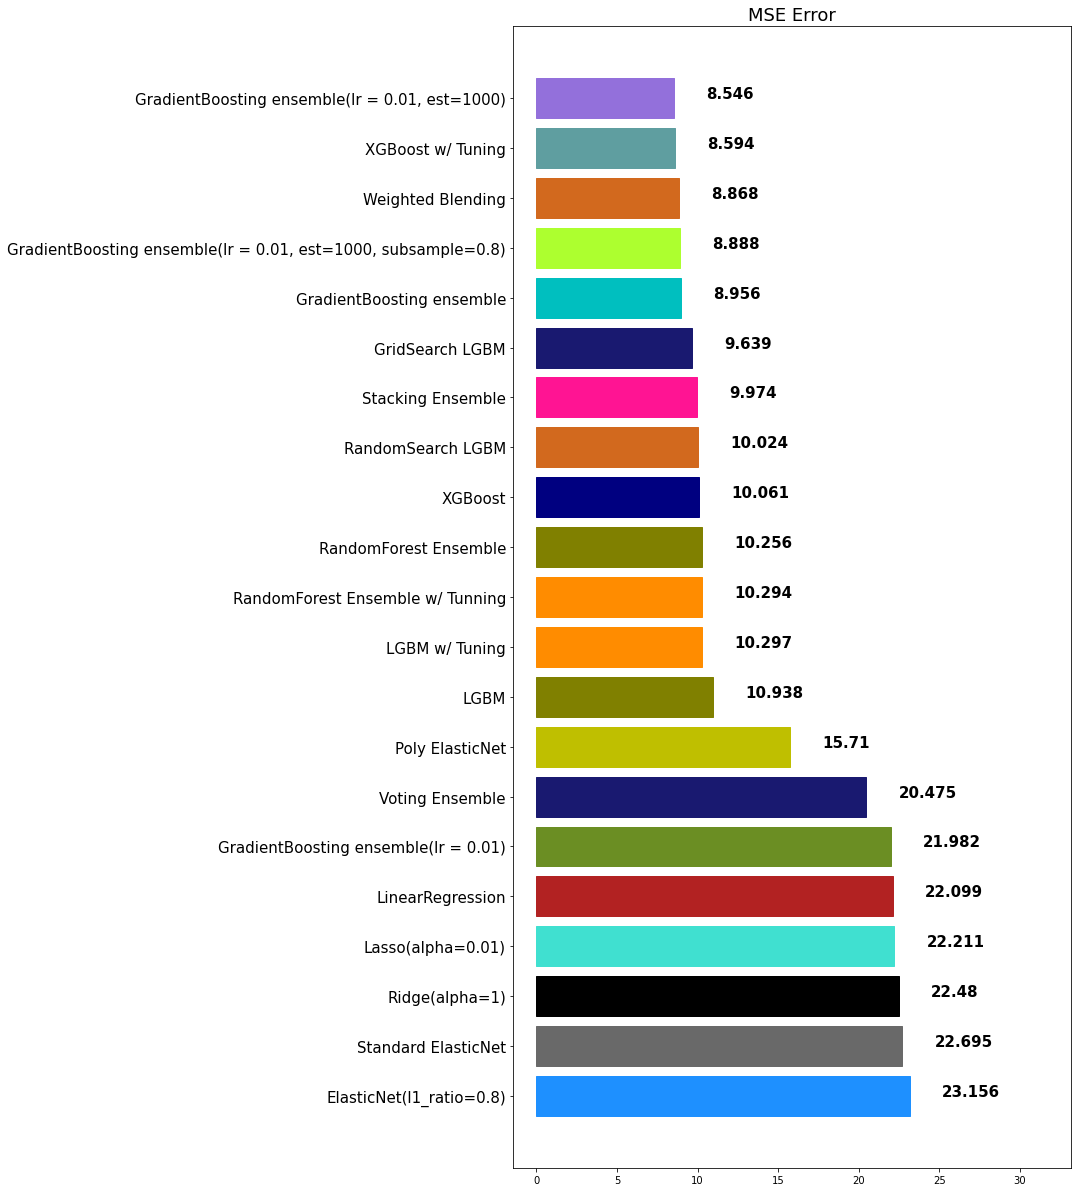

In [79]:
mse_eval('GridSearch LGBM', lgbm_best_pred, y_test)